***Customer Personality Analysis***


In this ipynb file we will discover a .csv file containing over 2000 customers and try to find relations between variables and use clustering to create models
describing customer behaviour.

In [1012]:
# import the libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

In [1013]:
# Load the data
data = pd.read_csv('marketing_campaign.csv', sep='\t')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


***Data encoding and Fixing***

In [1014]:
# print data types of the columns
print(data.dtypes)

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object


Deleting useless columns and filling null values.

In [1015]:
# replace null values in income column with the mean of the column
data['Income'] = data['Income'].fillna(data['Income'].mean())

In [1016]:
# z-cost contract and z_revenue is not given in website so lets delete them
data = data.drop(['Z_CostContact', 'Z_Revenue'], axis=1)
# drop the date column since it is not useful
data = data.drop("Dt_Customer", axis=1) 
# drop the ID column
data = data.drop("ID", axis=1)

Let's delete the outliers using IQR

In [1017]:
# delete outliers in columns usning IQR
# columns starting with acceepted, complain, response has only 0 and 1 so no outliers in them
# so dont use IQR for them
for column in data.columns:
    if column.startswith('Accepted') or column.startswith('Complain') or column.startswith('Response'):
        print('No outliers in column: ', column)
        continue
    if data[column].dtype != 'object':
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        length = len(data)
        data = data[~((data[column] < (Q1 - 2 * IQR)) | (data[column] > (Q3 + 2 * IQR)))]
        length_after = len(data)
        print('Deleted ', length - length_after, ' outliers in column: ', column)


Deleted  3  outliers in column:  Year_Birth
Deleted  8  outliers in column:  Income
Deleted  0  outliers in column:  Kidhome
Deleted  0  outliers in column:  Teenhome
Deleted  0  outliers in column:  Recency
Deleted  6  outliers in column:  MntWines
Deleted  182  outliers in column:  MntFruits
Deleted  157  outliers in column:  MntMeatProducts
Deleted  179  outliers in column:  MntFishProducts
Deleted  145  outliers in column:  MntSweetProducts
Deleted  127  outliers in column:  MntGoldProds
Deleted  28  outliers in column:  NumDealsPurchases
Deleted  14  outliers in column:  NumWebPurchases
Deleted  31  outliers in column:  NumCatalogPurchases
Deleted  69  outliers in column:  NumStorePurchases
Deleted  2  outliers in column:  NumWebVisitsMonth
No outliers in column:  AcceptedCmp3
No outliers in column:  AcceptedCmp4
No outliers in column:  AcceptedCmp5
No outliers in column:  AcceptedCmp1
No outliers in column:  AcceptedCmp2
No outliers in column:  Complain
No outliers in column:  Re

Now we deleted outliers let's delete columns with only one unique value

In [1018]:
# delete columns if there is only one unique value in the column
for column in data.columns:
    if len(data[column].unique()) == 1:
        print('Deleting column: ', column)
        data = data.drop([column], axis=1)

Education is ordinal data let's encode it starting from zero

In [1019]:
# print unique values of the education column
print(data['Education'].unique())


['Graduation' 'PhD' 'Basic' 'Master' '2n Cycle']


In [1020]:
 # Basic: 0, Graduation: 1, Master: 2, 2n Cycle: 3, Phd: 4
# encode the education column
data['Education'] = data['Education'].map({'Basic': 0, 'Graduation': 1, 'Master': 2, '2n Cycle': 3, 'PhD': 4})

In [1021]:
# print unique values of the education column
print(data['Marital_Status'].unique())

['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'YOLO']


In [1022]:
#write counts of every unique value in the Marital_Status column
print(data['Marital_Status'].value_counts())

Marital_Status
Married     509
Together    338
Single      273
Divorced    129
Widow        36
Alone         2
YOLO          2
Name: count, dtype: int64


Let's turn alone to single and YOLO to single.

In [1023]:
# replace alone with single
data['Marital_Status'] = data['Marital_Status'].replace('Alone', 'Single')
# replace YOLO with single
data['Marital_Status'] = data['Marital_Status'].replace('YOLO', 'Single')


***EDA***

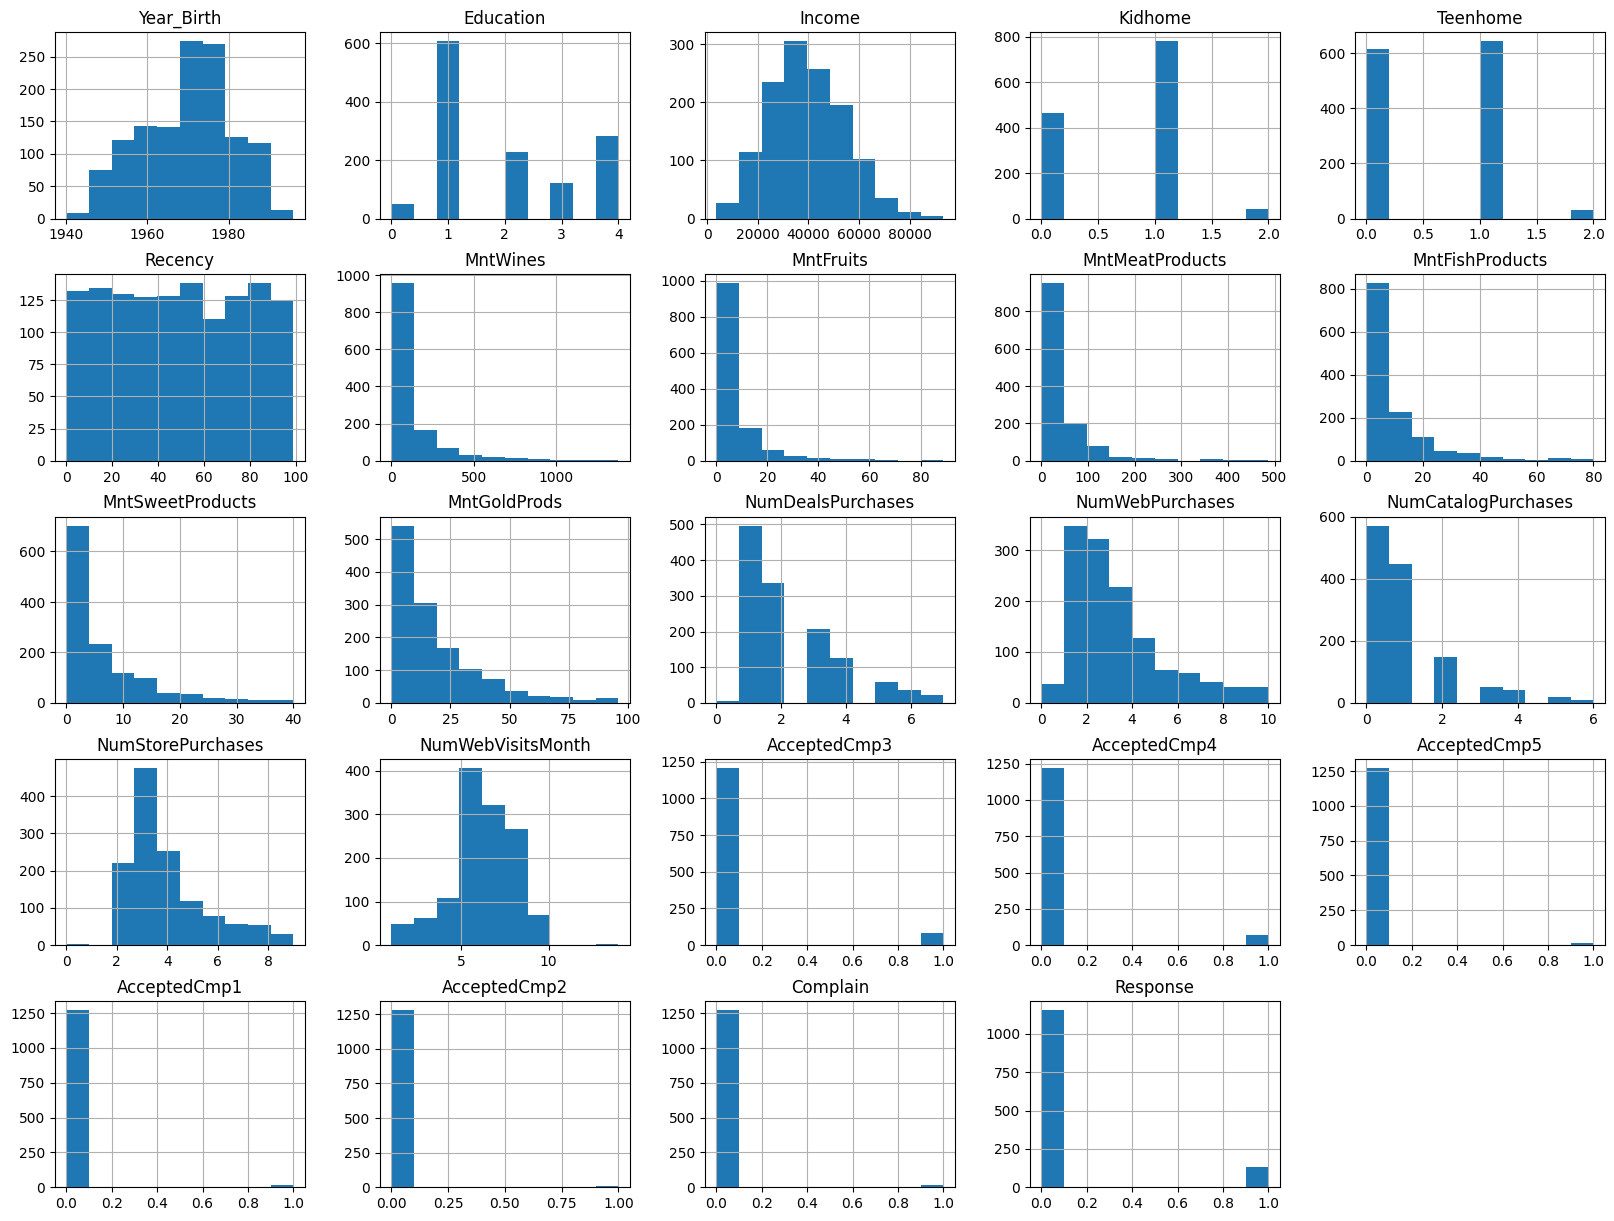

In [1024]:
# hist the data
data.hist(figsize=(20,15))
plt.show()

Looks like most of the data has a normal distribution. And some has a left-skewed distribution. Only interesting thins is recency with homogeneous distribution. And AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, Response, Complain having only 2 values with one of them being near 0.

Since marital status is nominal data let's encode it using one-hot encoding.

In [1025]:
# use one hot encoding to encode the Marital_Status column
data = pd.get_dummies(data, columns=['Marital_Status'])

Lets normalize the data

In [1026]:
#normalize the data using z-score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


In [1027]:
print(len(data))

1289


Let's look at the correlation matrix

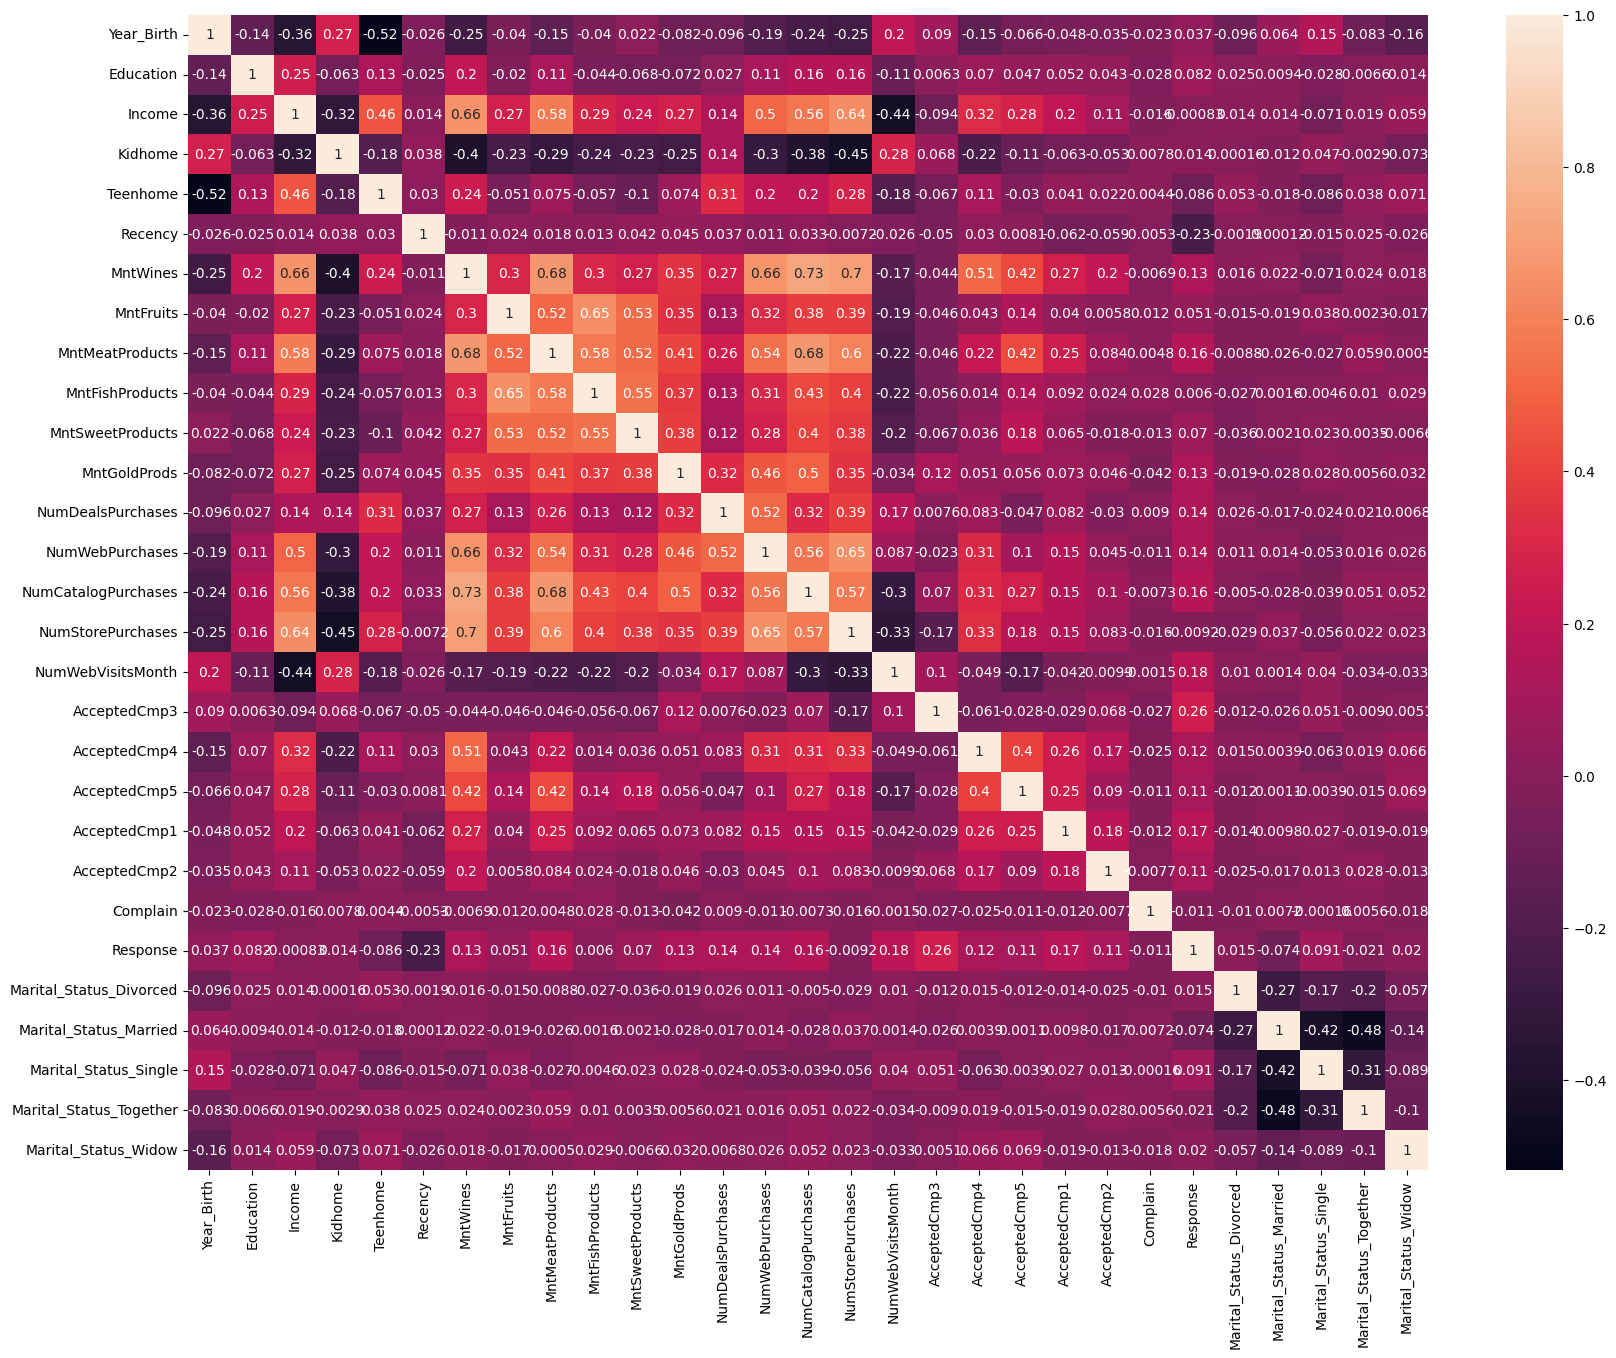

In [1028]:
# correlation matrix
corr = data.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr, annot=True)
plt.show()

Looking at the correlation matrix we can see that teenhome and kidhomw is correlated with age of individuals.Income is correlated with education. Interestingly more kids at home less web wisits a customer makes, less catalog purchases and less store purchases. Interestingly these are positively correlated with income.


Let's see the correlations higher than 0.6 or lower than -0.6

In [1029]:
# write code to print the every couple feature that has correlation > 0.6 or < -0.6
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.5:
            print(corr.columns[i], corr.columns[j], corr.iloc[i, j])

Teenhome Year_Birth -0.5180924501040024
MntWines Income 0.6619055232186775
MntMeatProducts Income 0.5805326104152991
MntMeatProducts MntWines 0.6789810322574747
MntMeatProducts MntFruits 0.5194777645165576
MntFishProducts MntFruits 0.6451135114603125
MntFishProducts MntMeatProducts 0.5779498976952318
MntSweetProducts MntFruits 0.5259762629993372
MntSweetProducts MntMeatProducts 0.5218777328403768
MntSweetProducts MntFishProducts 0.5489145515302853
NumWebPurchases Income 0.5047601698367136
NumWebPurchases MntWines 0.6645547620528999
NumWebPurchases MntMeatProducts 0.54105487018368
NumWebPurchases NumDealsPurchases 0.5209094003343475
NumCatalogPurchases Income 0.5628404299885
NumCatalogPurchases MntWines 0.7281344193673323
NumCatalogPurchases MntMeatProducts 0.6765393281228529
NumCatalogPurchases MntGoldProds 0.5006660901251947
NumCatalogPurchases NumWebPurchases 0.5561258400400063
NumStorePurchases Income 0.638611836641776
NumStorePurchases MntWines 0.7000408746108538
NumStorePurchases 

Looking at the high correlations we see that products are correlated with each other. People who buy meat also buy wine, people who buy wine buy fruit, people who buy fish buy sweet products. Also web visits are correlated with deal purchases. While catalog purchases are correlated with Gold products. Looks like income, meat and wine is correlated with purchases in general. Also people who accepted campaign 4 love wines.

***Clustering***

In this section we will use KMeans to cluster the data and try to find the best number of clusters using the elbow method.
K-means is a popular clustering algorithm that aims to partition n observations into k clusters. It does this using an iterative process that assigns each observation to the cluster whose mean has the least squared Euclidean distance, and then recalculates the mean of each cluster. This process continues until the cluster assignments no longer change, or the maximum number of iterations is reached.
Simplicity and Speed: K-means is a relatively simple and efficient algorithm that can handle large datasets with many variables. It converges quickly, making it suitable for applications where real-time or near real-time analysis is required.

Interpretable Results: K-means produces easily interpretable results. Each cluster represents a distinct group of customers based on similarity in their features. This allows businesses to understand and target specific customer segments, tailoring their marketing or business strategies accordingly.

Scalability: K-means is scalable, which means it can handle a large number of data points and clusters without significant computational overhead. This makes it suitable for analyzing large customer datasets commonly encountered in e-commerce, marketing, and other industries.

In [1030]:
# use k-means clustering to cluster the data
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
# give scipy a known seed
np.random.seed(110)
values = {}
# use elbow method to find the best k
for k in range(1, 10):
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(data)
    kmeanModel.fit(data)
    values[k] = sum(np.min(cdist(data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / data.shape[0]

C:\Users\Salih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Salih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Salih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the v

In [1031]:
for key, val in values.items():
    print(f'{key} : {val}')

1 : 4.927084332275399
2 : 4.548556325574084
3 : 4.465381285323295
4 : 4.317985108920246
5 : 4.2285418481278185
6 : 4.080747825351045
7 : 4.039765394435633
8 : 3.959643252521254
9 : 3.8188190199233087


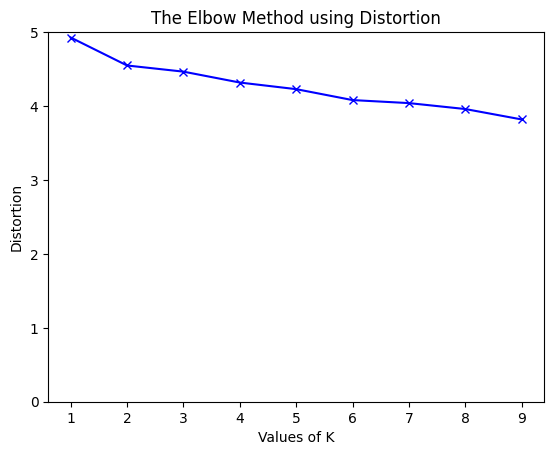

In [1032]:
# plot the elbow method 
plt.plot(range(1, 10), values.values(), 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
# make Distortion 0 to 5
plt.ylim(0, 5)
plt.show()

We will choose 3 since more than that will overfit the model instead of giving us valuable information.


In [1033]:
# take 4 as the best k
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
y_kmeans = kmeans.predict(data)
data['Cluster'] = y_kmeans

C:\Users\Salih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\515579169.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=data["Cluster"], palette=palette)


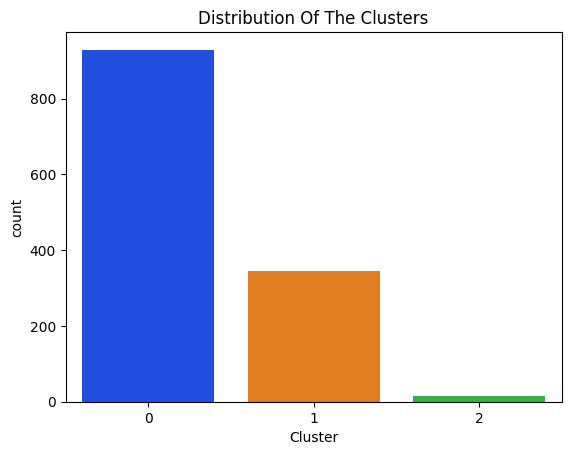

In [1034]:
# create a palette
palette = sns.color_palette("bright", 3)
# add a column color to the data using the palette with the cluster column
data['Color'] = data['Cluster'].map({0: palette[0], 1: palette[1], 2: palette[2]})
pl = sns.countplot(x=data["Cluster"], palette=palette)
pl.set_title("Distribution Of The Clusters")
plt.show()

Looks like most people fall under blue some in orange and very few in green.

C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\2085454318.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['Education'], data['Income'], c=data['Color'], s=50, cmap='viridis')


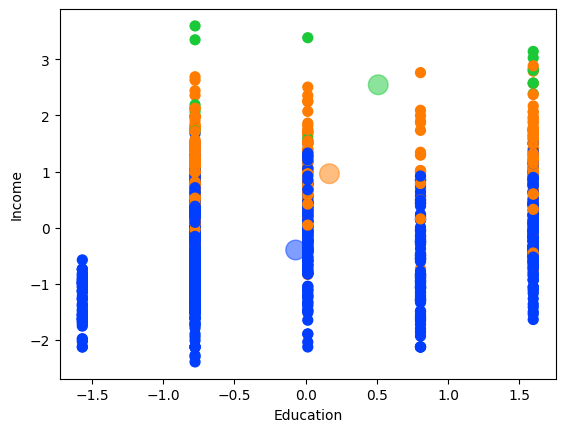

In [1052]:
# plot the clusters education and ıncome with palette
plt.scatter(data['Education'], data['Income'], c=data['Color'], s=50, cmap='viridis')
# name the x and y axis
plt.xlabel('Education')
plt.ylabel('Income')
centers = kmeans.cluster_centers_
# create centers data frame with the centers of the clusters
plt.scatter(centers[:, 1], centers[:, 2], c=palette, s=200, alpha=0.5)
plt.show()

Looks like blue column is composed of people with average income and education. While orange is composed of people with higher income and education. Green is composed of people with even higher income and education.

C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\3570043708.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['MntWines'], data['MntFruits'], c=data['Color'], s=50, cmap='viridis')


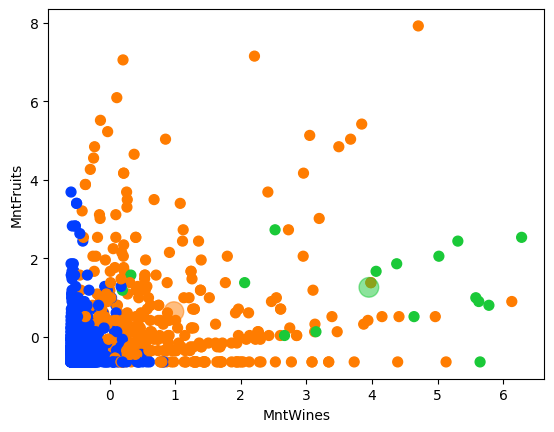

In [1054]:
plt.scatter(data['MntWines'], data['MntFruits'], c=data['Color'], s=50, cmap='viridis')
# name the x and y axis
plt.xlabel('MntWines')
plt.ylabel('MntFruits')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 6], centers[:, 7], c=palette, s=200, alpha=0.5)
plt.show()

Looks like blue people don't spend much on wine or Fruits, while green people spend so much on wine and some on fruits. Orange people spend a some on wine and fruits.

C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\3599072506.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['Kidhome'], data['Year_Birth'], c=data['Color'], s=50, cmap='viridis')


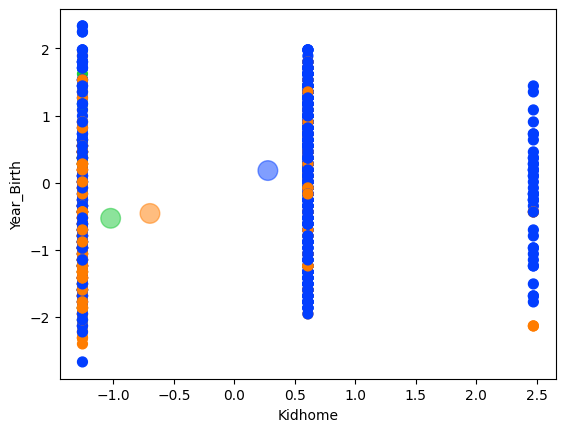

In [1058]:
plt.scatter(data['Kidhome'], data['Year_Birth'], c=data['Color'], s=50, cmap='viridis')
# name the x and y axis
plt.xlabel('Kidhome')
plt.ylabel('Year_Birth')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 3], centers[:, 0], c=palette, s=200, alpha=0.5)
plt.show()

Looks like blue people have more than average kids and lower age, while green and orange people have less than average kids and they have higher age. 

C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\1977482688.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['AcceptedCmp1'], data['AcceptedCmp2'], c=data['Color'], s=50, cmap='viridis')


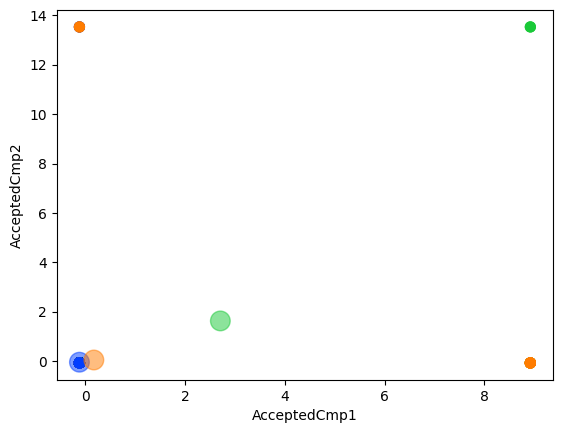

In [1059]:
# plot the clusters
#Index(['Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Recency',
#       6'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
#       10'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
#       13'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
#       16'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#       20'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
#       24'Marital_Status_Divorced', 'Marital_Status_Married',
#       26'Marital_Status_Single', 'Marital_Status_Together',
#       28'Marital_Status_Widow'],
#      dtype='object')
plt.scatter(data['AcceptedCmp1'], data['AcceptedCmp2'], c=data['Color'], s=50, cmap='viridis')
# name the x and y axis
plt.xlabel('AcceptedCmp1')
plt.ylabel('AcceptedCmp2')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 20], centers[:, 21], c=palette, s=200, alpha=0.5)
plt.show()

looks like only greeen people accetped campaign 1 and 2 while orange and blue did not.

C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\3584762585.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['AcceptedCmp3'], data['AcceptedCmp4'], c=data['Color'], s=50, cmap='viridis')


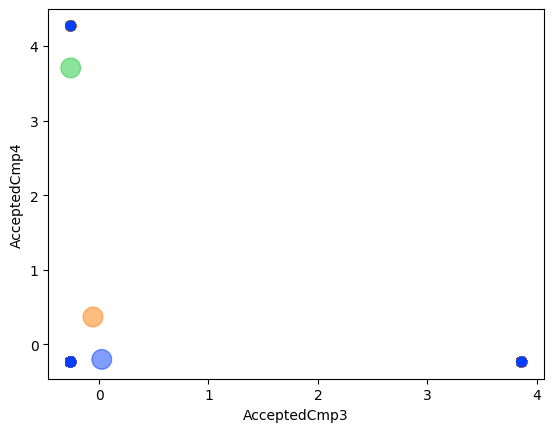

In [1060]:
# plot the clusters
#Index(['Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Recency',
#       6'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
#       10'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
#       13'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
#       16'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#       20'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
#       24'Marital_Status_Divorced', 'Marital_Status_Married',
#       26'Marital_Status_Single', 'Marital_Status_Together',
#       28'Marital_Status_Widow'],
#      dtype='object')
plt.scatter(data['AcceptedCmp3'], data['AcceptedCmp4'], c=data['Color'], s=50, cmap='viridis')
# name the x and y axis
plt.xlabel('AcceptedCmp3')
plt.ylabel('AcceptedCmp4')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 17], centers[:, 18], c=palette, s=200, alpha=0.5)
plt.show()

Again looks like mostly greeen people accepted campaign 4.

C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\2043276813.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['AcceptedCmp5'], data['Complain'], c=data['Color'], s=50, cmap='viridis')


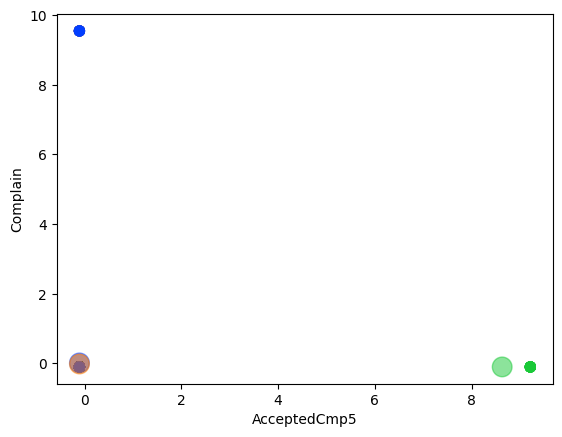

In [1061]:
# plot the clusters
#Index(['Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Recency',
#       6'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
#       10'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
#       13'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
#       16'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#       20'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
#       24'Marital_Status_Divorced', 'Marital_Status_Married',
#       26'Marital_Status_Single', 'Marital_Status_Together',
#       28'Marital_Status_Widow'],
#      dtype='object')
plt.scatter(data['AcceptedCmp5'], data['Complain'], c=data['Color'], s=50, cmap='viridis')
# name the x and y axis
plt.xlabel('AcceptedCmp5')
plt.ylabel('Complain')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 19], centers[:, 22], c=palette, s=200, alpha=0.5)
plt.show()

Looks like nobody complains. And only green people accepted campaign 5.

C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\1726143934.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['Response'], data['Teenhome'], c=data['Color'], s=50, cmap='viridis')


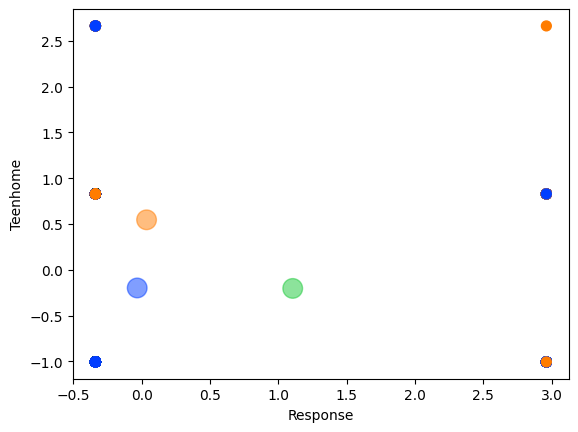

In [1062]:
# plot the clusters
#Index(['Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Recency',
#       6'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
#       10'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
#       13'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
#       16'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#       20'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
#       24'Marital_Status_Divorced', 'Marital_Status_Married',
#       26'Marital_Status_Single', 'Marital_Status_Together',
#       28'Marital_Status_Widow'],
#      dtype='object')
plt.scatter(data['Response'], data['Teenhome'], c=data['Color'], s=50, cmap='viridis')
# name the x and y axis
plt.xlabel('Response')
plt.ylabel('Teenhome')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 23], centers[:, 4], c=palette, s=200, alpha=0.5)
plt.show()

Looks like orange people have higher amount of teens and green people have high response rate.

C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\439548208.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['MntSweetProducts'], data['MntGoldProds'], c=data['Color'], s=50, cmap='viridis')


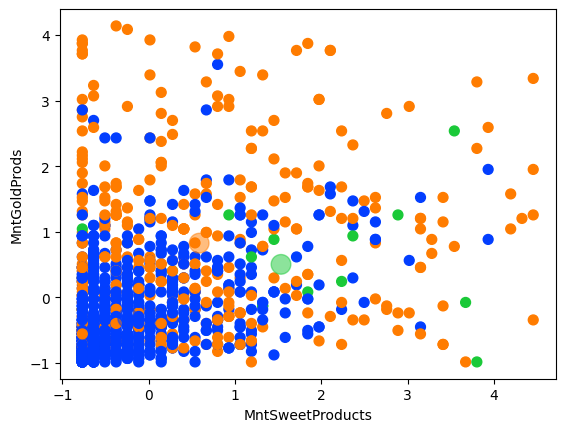

In [1063]:
# plot the clusters
#Index(['Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Recency',
#       6'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
#       10'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
#       13'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
#       16'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#       20'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
#       24'Marital_Status_Divorced', 'Marital_Status_Married',
#       26'Marital_Status_Single', 'Marital_Status_Together',
#       28'Marital_Status_Widow'],
#      dtype='object')
plt.scatter(data['MntSweetProducts'], data['MntGoldProds'], c=data['Color'], s=50, cmap='viridis')
# name the x and y axis
plt.xlabel('MntSweetProducts')
plt.ylabel('MntGoldProds')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 10], centers[:, 11], c=palette, s=200, alpha=0.5)
plt.show()

Looks like blue people don't like to buy lots of gold or sweets. While orange people have high variance looks like they bought a lot of gold and a lot of sweets. Green people bought lots of sweets and some gold.

C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\3227435194.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['NumDealsPurchases'], data['NumWebPurchases'], c=data['Color'], s=50, cmap='viridis')


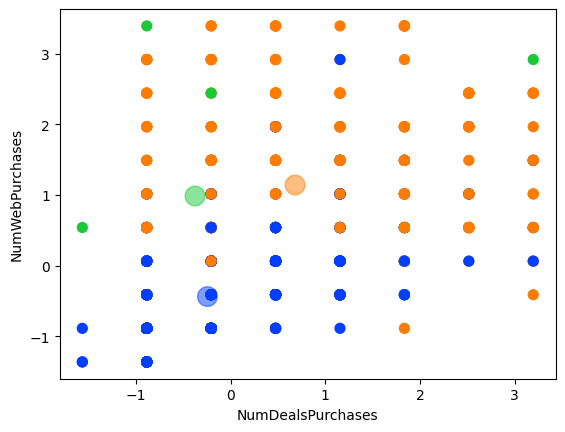

In [1064]:
# plot the clusters
#Index(['Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Recency',
#       6'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
#       10'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
#       13'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
#       16'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#       20'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
#       24'Marital_Status_Divorced', 'Marital_Status_Married',
#       26'Marital_Status_Single', 'Marital_Status_Together',
#       28'Marital_Status_Widow'],
#      dtype='object')
plt.scatter(data['NumDealsPurchases'], data['NumWebPurchases'], c=data['Color'], s=50, cmap='viridis')
# name the x and y axis
plt.xlabel('NumDealsPurchases')
plt.ylabel('NumWebPurchases')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 12], centers[:, 13], c=palette, s=200, alpha=0.5)
plt.show()

Orange people like bouth deals and web purchases. While blue people don't like to buy from any of them. Green people like to buy from web.

C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\3657457441.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['NumCatalogPurchases'], data['NumStorePurchases'], c=data['Color'], s=50, cmap='viridis')


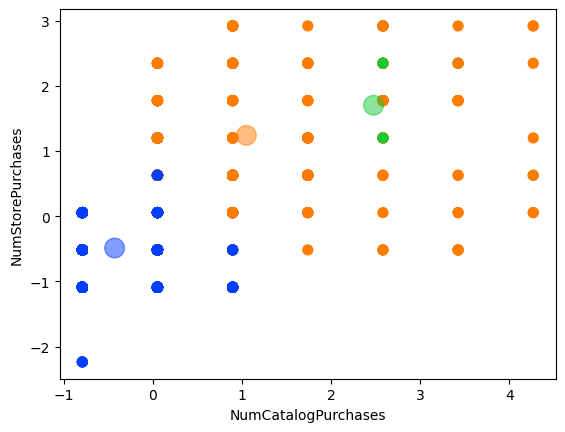

In [1065]:
# plot the clusters
#Index(['Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Recency',
#       6'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
#       10'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
#       13'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
#       16'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#       20'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
#       24'Marital_Status_Divorced', 'Marital_Status_Married',
#       26'Marital_Status_Single', 'Marital_Status_Together',
#       28'Marital_Status_Widow'],
#      dtype='object')
plt.scatter(data['NumCatalogPurchases'], data['NumStorePurchases'], c=data['Color'], s=50, cmap='viridis')
# name the x and y axis
plt.xlabel('NumCatalogPurchases')
plt.ylabel('NumStorePurchases')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 14], centers[:, 15], c=palette, s=200, alpha=0.5)
plt.show()

Looks like blue people don't use catalogs or store so ofthen. while orange people use both often and green people use them the most.

C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\833988373.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['NumWebVisitsMonth'], data['Marital_Status_Divorced'], c=data['Color'], s=50, cmap='viridis')


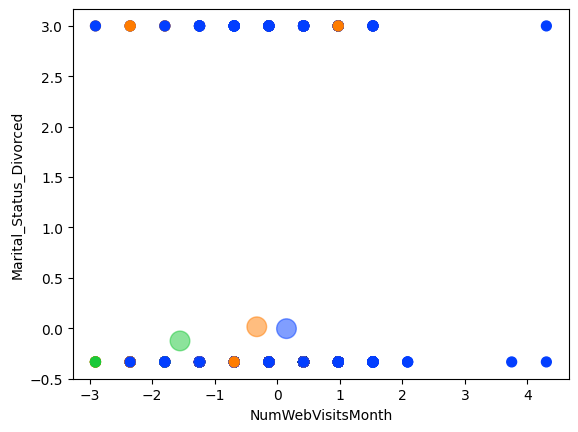

In [1066]:
# plot the clusters
#Index(['Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Recency',
#       6'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
#       10'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
#       13'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
#       16'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#       20'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
#       24'Marital_Status_Divorced', 'Marital_Status_Married',
#       26'Marital_Status_Single', 'Marital_Status_Together',
#       28'Marital_Status_Widow'],
#      dtype='object')
plt.scatter(data['NumWebVisitsMonth'], data['Marital_Status_Divorced'], c=data['Color'], s=50, cmap='viridis')
# name the x and y axis
plt.xlabel('NumWebVisitsMonth')
plt.ylabel('Marital_Status_Divorced')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 16], centers[:, 24], c=palette, s=200, alpha=0.5)
plt.show()

Looks like no group has lots of divorced in them but green people don't visit the web often.

C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\1030523239.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['Marital_Status_Married'], data['Marital_Status_Single'], c=data['Color'], s=50, cmap='viridis')


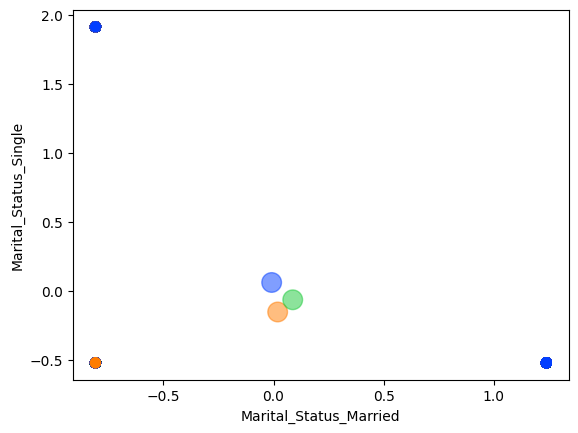

In [1067]:
# plot the clusters
#Index(['Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Recency',
#       6'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
#       10'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
#       13'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
#       16'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#       20'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
#       24'Marital_Status_Divorced', 'Marital_Status_Married',
#       26'Marital_Status_Single', 'Marital_Status_Together',
#       28'Marital_Status_Widow'],
#      dtype='object')
plt.scatter(data['Marital_Status_Married'], data['Marital_Status_Single'], c=data['Color'], s=50, cmap='viridis')
# name the x and y axis
plt.xlabel('Marital_Status_Married')
plt.ylabel('Marital_Status_Single')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 25], centers[:, 26], c=palette, s=200, alpha=0.5)
plt.show()

In terms of marriage status and single status we don't see big difference between groups.


C:\Users\Salih\AppData\Local\Temp\ipykernel_15972\1843874753.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['Marital_Status_Together'], data['Marital_Status_Widow'], c=data['Color'], s=50, cmap='viridis')


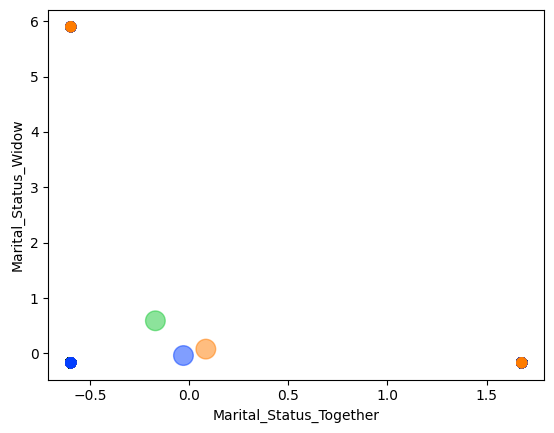

In [1068]:
# plot the clusters
#Index(['Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Recency',
#       6'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
#       10'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
#       13'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
#       16'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#       20'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
#       24'Marital_Status_Divorced', 'Marital_Status_Married',
#       26'Marital_Status_Single', 'Marital_Status_Together',
#       28'Marital_Status_Widow'],
#      dtype='object')
plt.scatter(data['Marital_Status_Together'], data['Marital_Status_Widow'], c=data['Color'], s=50, cmap='viridis')
# name the x and y axis
plt.xlabel('Marital_Status_Together')
plt.ylabel('Marital_Status_Widow')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 27], centers[:, 28], c=palette, s=200, alpha=0.5)
plt.show()

Looks like widows are mostly in green while other groups are so close to mean we can't say anything about them.
